## Procedurally-Generated Narrative

In this example, we will examine how to (crudely) combine an agent-based model with text from a Shakespearean play to generate a new dialog.  Before we jump into the specifics of the implementation, let's talk about agent-based models.

### Agent-Based Models

An agent-based model (ABM) is a class of computational models for simulating the actions and interactions of autonomous agents (both individual or collective entities such as organizations or groups) with a view to assessing their effects on the system as a whole. 

Most agent-based models are composed of: (1) numerous agents specified at various scales (typically referred to as agent-granularity); (2) decision-making heuristics; (3) learning rules or adaptive processes; (4) an interaction topology; and (5) an environment. ABMs are typically implemented as computer simulations, either as custom software, or via ABM toolkits, and this software can be then used to test how changes in individual behaviors will affect the system's emerging overall behavior. [https://en.wikipedia.org/wiki/Agent-based_model]

You can review a number of well-known agent-based models here: https://ccl.northwestern.edu/netlogo/models/

### Schelling Segregation model
This example of implementation of Schelling Segregation model is adapted from https://colab.research.google.com/github/QuantEcon/lecture-python.notebooks/blob/master/schelling.ipynb

In 1969, Thomas C. Schelling developed a simple but striking model of racial segregation [Sch69].

His model studies the dynamics of racially mixed neighborhoods.

Like much of Schelling’s work, the model shows how local interactions can lead to surprising aggregate structure.

In particular, it shows that relatively mild preference for neighbors of similar race can lead in aggregate to the collapse of mixed neighborhoods, and high levels of segregation.

In recognition of this and other research, Schelling was awarded the 2005 Nobel Prize in Economic Sciences (joint with Robert Aumann).

In [19]:
# Import necessary libraries
import random
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

### Process and Parse Romeo and Juliet Text
Before we can connect the Romeo and Juliet text to Schelling's agent-based model, we need to do a bit of preprocessing to make sure that our text is in a usable format.  The entire text of Romeo and Juliet is available as a free download from Project Guttenberg: Romeo and Juliet: https://www.gutenberg.org/ebooks/1513

In [70]:
# Before we import the text, let's create two lists of characters.
# Note the format - we are storing characters in Python dictionaries.  
# Dictionaries are Python data structures that store data in key/value pairs
# In our family member dictionaries the keys are the names of characters in Romeo and Juliet,
# and the values are initialized as empty lists
# We will store lists of each character's statements in the corresponding dictionary values

# List of Mongatue family members
montagues = {
    'MERCUTIO' : [], 
    'MONTAGUE' : [], 
    'LADY MONTAGUE' : [], 
    'ROMEO' : [],
    'BENVOLIO' : [], 
    'ABRAM' : [], 
    'BALTHASAR' : []
}

# List of Capulet family members
capulets = {
    'CAPULET' : [], 
    'LADY CAPULET' : [],
    'JULIET' : [], 
    'TYBALT' : [], 
    'CAPULET’S COUSIN' : [],
    'NURSE' : [], 
    'PETER' : [], 
    'SAMPSON' : [], 
    'GREGORY' : []
}


In [21]:
# Open the text file 
play = open('romeo_juliet.txt')

# Read the text from the file
play_text = play.read()

#print(play_text)

In [71]:
# Parse the text data

# Iterate through all characters in Montague dictionary:
for character, statements in montagues.items():
    start = 0
    # Inner loop will iterate until it can no longer find a
    # character's name in the body of text
    while start != -1: 
        # Find the first occurance of a character's name
        start = play_text.find(character + '.\n') 
        
        # Truncate the text so that it starts from the location
        # of the character's name. Store truncated text in a 
        # temp variable
        temp = play_text[start:]

        # Find where a character's statement ends.  If you examine the text
        # you will find that in each dialog characters' statements are separated
        # by two blank lines 
        stop = temp.find('\n\n')
        
        # Extract an individual statement by slicing the text
        # stored in the temp variable from the beginning of the text
        # to the end of the statement (location of a double blank line)
        statement = temp[:stop]
        #print(statement)
        
        # Add statement to the statements list of a corresponding Montague character
        montagues[character].append(statement)
        
        # Remove statement from the body of text
        play_text = play_text.replace(statement, '')
        
# Iterate through all characters in Capulet dictionary:
for character, statements in capulets.items():
    start = 0
    
    # Inner loop will iterate until it can no longer find a
    # character's name in the body of text
    while start != -1:
        # Find the first occurance of a character's name
        start = play_text.find(character + '.\n')

        # Truncate the text so that it starts from the location
        # of the character's name. Store truncated text in a 
        # temp variable
        temp = play_text[start:]
        
        # Find where a character's statement ends.  If you examine the text
        # you will find that in each dialog characters' statements are separated
        # by two blank lines
        stop = temp.find('\n\n')

        # Extract an individual statement by slicing the text
        # stored in the temp variable from the beginning of the text
        # to the end of the statement (location of a double blank line)
        statement = temp[:stop]
        #print(statement)
        
        # Add statement to the statements list of a corresponding Capulet character
        capulets[character].append(statement)
        
        # Remove statement from the body of text
        play_text = play_text.replace(statement, '')



## Implementation Details of Schelling's Model



### Set-Up

Suppose we have two types of people: orange people and green people.

For the purpose of this lecture, we will assume there are 250 of each type.

These agents all live on a single unit square.

The location of an agent is just a point $ (x, y) $,  where $ 0 < x, y < 1 $.

### Preferences

We will say that an agent is *happy* if half or more of her 10 nearest neighbors are of the same type.

Here ‘nearest’ is in terms of [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance).

An agent who is not happy is called *unhappy*.

An important point here is that agents are not averse to living in mixed areas.

They are perfectly happy if half their neighbors are of the other color.

### Behavior

Initially, agents are mixed together (integrated).

In particular, the initial location of each agent is an independent draw from a bivariate uniform distribution on $ S = (0, 1)^2 $.

Now, cycling through the set of all agents, each agent is now given the chance to stay or move.

We assume that each agent will stay put if they are happy and move if unhappy.

The algorithm for moving is as follows

1. Draw a random location in $ S $  
1. If happy at new location, move there  
1. Else, go to step 1  


In this way, we cycle continuously through the agents, moving as required.

We continue to cycle until no one wishes to move.

In [72]:
random.seed(10)  # For reproducible random numbers

# Each agent in the model is represented by an Agent object
class Agent:
    # Class constructor - initializes all the properties of an Agent object
    def __init__(self, agent_type, agent_name, agent_statement):
        self.type = agent_type
        self.name = agent_name
        self.statement = agent_statement.strip().replace('\n', '') # A bit of cleaning...
        self.draw_location()

    # Randomly place an agent on the virtual "grid"
    def draw_location(self):
        self.location = random.uniform(0, 1), uniform(0, 1)

        
    # Compute the Euclidean distance between self and other agent.
    def get_distance(self, other):
        a = (self.location[0] - other.location[0])**2
        b = (self.location[1] - other.location[1])**2
        return sqrt(a + b)

    # Determine if an agent is happy
    # True if sufficient number of nearest neighbors are of the same type.
    def happy(self, agents):
        distances = []
        # distances is a list of pairs (d, agent), where d is distance from
        # agent to self
        for agent in agents:
            if self != agent:
                distance = self.get_distance(agent)
                distances.append((distance, agent))
        
        # == Sort from smallest to largest, according to distance == #
        distances.sort()
        
        # == Extract the neighboring agents == #
        neighbors = [agent for d, agent in distances[:num_neighbors]]
        # Unlike in the original model code, we will save the list
        # of nearest neighbors as a property of each agent - this way
        # each agent always knows its nearest neighbors
        self.neighbors = neighbors
        
        # == Count how many neighbors have the same type as self == #
        num_same_type = sum(self.type == agent.type for agent in neighbors)
        return num_same_type >= require_same_type

    
    # Update agent's position.
    # If agent is not happy, then randomly choose new locations until happy.
    def update(self, agents):
        while not self.happy(agents):
            self.draw_location()





In [73]:
num_of_type_0 = len(capulets.items()) # Number of Capulet agents
num_of_type_1 = len(montagues.items()) # Number of Montague agents
num_neighbors = 4 # Number of agents regarded as neighbors
require_same_type = 3 # Want at least this many neighbors to be same type

# == Create a list of agents == #
agents = []

# We are going to iterate through the dictionary of characters from the 
# Capulet family and create an agent for each character
for character_name, statement_list in capulets.items():
    # Dictionary key is the name of the agent/character
    agent_name = character_name 
    
    # We will randomly select each agent's statement from 
    # the list of all dialog statements extracted from the 
    # text
    agent_statement = random.choice(statement_list)
    
    # Create a new agent
    agent = Agent(0, agent_name, agent_statement)

    # Add agents of type 0 (Capulet) to the list
    agents.append(agent) 
    

# We are going to iterate through the dictionary of characters from the 
# Montague family and create an agent for each character
for character_name, statement_list in montagues.items():
    # Dictionary key is the name of the agent/character
    agent_name = character_name 
    
    # We will randomly select each agent's statement from 
    # the list of all dialog statements extracted from the 
    # text
    agent_statement = random.choice(statement_list)
    
    # Create a new agent
    agent = Agent(1, agent_name, agent_statement)

    # Add agents of type 1 (Montague) to the list
    agents.append(agent) 



count = 1
# ==  Loop until none wishes to move == #
while True:
    print('Entering loop ', count)
    count += 1
    no_one_moved = True
    for agent in agents:
        old_location = agent.location
        agent.update(agents)
        if agent.location != old_location:
            no_one_moved = False
    if no_one_moved:
        break

print('Converged, terminating.')


Entering loop  1
Entering loop  2
Entering loop  3
Converged, terminating.


In [74]:
# Let's see where all of our agents are in regards to each other
for agent in agents: # Iterate through the list of agents
    print(agent.name + " neighbors: ")
    for n in agent.neighbors: # For each agent, iterate through its neighbors
        print('\t' + n.name)

CAPULET neighbors: 
	LADY CAPULET
	PETER
	GREGORY
	JULIET
LADY CAPULET neighbors: 
	CAPULET
	PETER
	JULIET
	GREGORY
JULIET neighbors: 
	LADY CAPULET
	CAPULET
	PETER
	TYBALT
TYBALT neighbors: 
	PETER
	JULIET
	CAPULET
	LADY CAPULET
CAPULET’S COUSIN neighbors: 
	SAMPSON
	NURSE
	GREGORY
	PETER
NURSE neighbors: 
	SAMPSON
	CAPULET’S COUSIN
	GREGORY
	PETER
PETER neighbors: 
	CAPULET
	GREGORY
	LADY CAPULET
	TYBALT
SAMPSON neighbors: 
	NURSE
	CAPULET’S COUSIN
	GREGORY
	PETER
GREGORY neighbors: 
	CAPULET
	PETER
	SAMPSON
	NURSE
MERCUTIO neighbors: 
	BALTHASAR
	LADY MONTAGUE
	ROMEO
	BENVOLIO
MONTAGUE neighbors: 
	ABRAM
	BENVOLIO
	LADY MONTAGUE
	MERCUTIO
LADY MONTAGUE neighbors: 
	BENVOLIO
	MONTAGUE
	MERCUTIO
	ABRAM
ROMEO neighbors: 
	BALTHASAR
	MERCUTIO
	LADY MONTAGUE
	BENVOLIO
BENVOLIO neighbors: 
	LADY MONTAGUE
	ABRAM
	MONTAGUE
	MERCUTIO
ABRAM neighbors: 
	MONTAGUE
	BENVOLIO
	LADY MONTAGUE
	MERCUTIO
BALTHASAR neighbors: 
	ROMEO
	MERCUTIO
	LADY MONTAGUE
	LADY CAPULET


### Network Visualization
We can also visualize the neighbor-to-neighbor relationships using a network visualization

In [63]:
# We'll start by importing the networkx library
# networkx is commonly used for creating, querying, and visualizing networks in Python
import networkx as nx

In [64]:
# Creating a Graph 
G = nx.Graph() # Right now G is empty
G


In [65]:
# Create node in the graph, where each node is an agent
for agent in agents:
    G.add_node(agent.name) 
    
G.nodes()

NodeView(('CAPULET', 'LADY CAPULET', 'JULIET', 'TYBALT', 'CAPULET’S COUSIN', 'NURSE', 'PETER', 'SAMPSON', 'GREGORY', 'MERCUTIO', 'MONTAGUE', 'LADY MONTAGUE', 'ROMEO', 'BENVOLIO', 'ABRAM', 'BALTHASAR'))

In [66]:
# Add edges 
for agent in agents: # Iterate through the list of agents
    for n in agent.neighbors: # For each agent, iterate through its neighbors
        G.add_edge(agent.name, n.name) # Create an edge
        

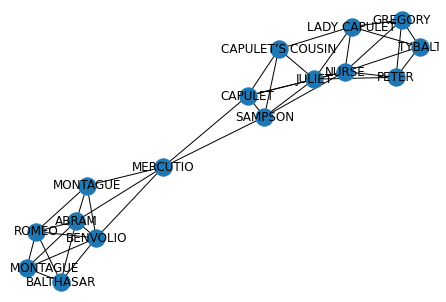

In [67]:
# Visualize the network
nx.draw(G, with_labels=True)

### Generate dialog
Now, the moment we have all been waiting for - let's generate the dialog.  For the purposes of this example we will randomly select one of the neighbors to participate in the conversation.  For your homework assignment, be a little more creative than that:)

In [68]:
for agent in agents: # Iterate through the list of agents
    print(agent.statement)
    # Randomly select a neighbor
    n = random.choice(agent.neighbors)
    print(n.statement)

CAPULET.Ay, you have been a mouse-hunt in your time;But I will watch you from such watching now.
SAMPSON.Me they shall feel while I am able to stand: and ’tis known I am apretty piece of flesh.

JULIET.Tell me not, Friar, that thou hear’st of this,Unless thou tell me how I may prevent it.If in thy wisdom, thou canst give no help,Do thou but call my resolution wise,And with this knife I’ll help it presently.God join’d my heart and Romeo’s, thou our hands;And ere this hand, by thee to Romeo’s seal’d,Shall be the label to another deed,Or my true heart with treacherous revoltTurn to another, this shall slay them both.Therefore, out of thy long-experienc’d time,Give me some present counsel, or behold’Twixt my extremes and me this bloody knifeShall play the empire, arbitrating thatWhich the commission of thy years and artCould to no issue of true honour bring.Be not so long to speak. I long to die,If what thou speak’st speak not of remedy.
JULIET.Tell me not, Friar, that thou hear’st of this